# Supernova MCMC and HMC exercise

Florent Leclercq<br>
Imperial Centre for Inference and Cosmology, Imperial College London<br>
<a href="mailto:florent.leclercq@polytechnique.org">florent.leclercq@polytechnique.org</a>

In [1]:
import numpy as np
import scipy
import scipy.stats as ss
import matplotlib.pyplot as plt
np.random.seed(3)

## Theory (two-parameter problem)

In [2]:
def mu(z,Omega_m,h):
    return 25. - 5.*np.log10(h) + 5.*np.log10(D_L(z,Omega_m))

def D_L(z,Omega_m):
    return 3000.*(1+z)*(eta(1.,Omega_m) - eta(1/(1.+z),Omega_m))

def eta(a,Omega_m):
    s=((1.-Omega_m)/Omega_m)**(1/3.)
    return 2*np.sqrt(s**3+1.) * (1/a**4 - 0.1540*s/a**3 + 0.4304*s**2/a**2 + 0.19097*s**3/a + 0.066941*s**4)**(-1/8.)

In [3]:
zs=np.linspace(1e-3,2,100)
h=0.7
mus={}
for Omega_m in [0.2,0.3,0.4,0.5]:
    mus[Omega_m]=mu(zs,Omega_m,h)

## Data and covariance matrix

In [4]:
zdata, data = np.loadtxt("data/jla_mub.txt",unpack=True)
cov = np.loadtxt("data/jla_mub_covmatrix.txt").reshape(31,31)

Text(0.5, 1.0, 'covariance matrix')

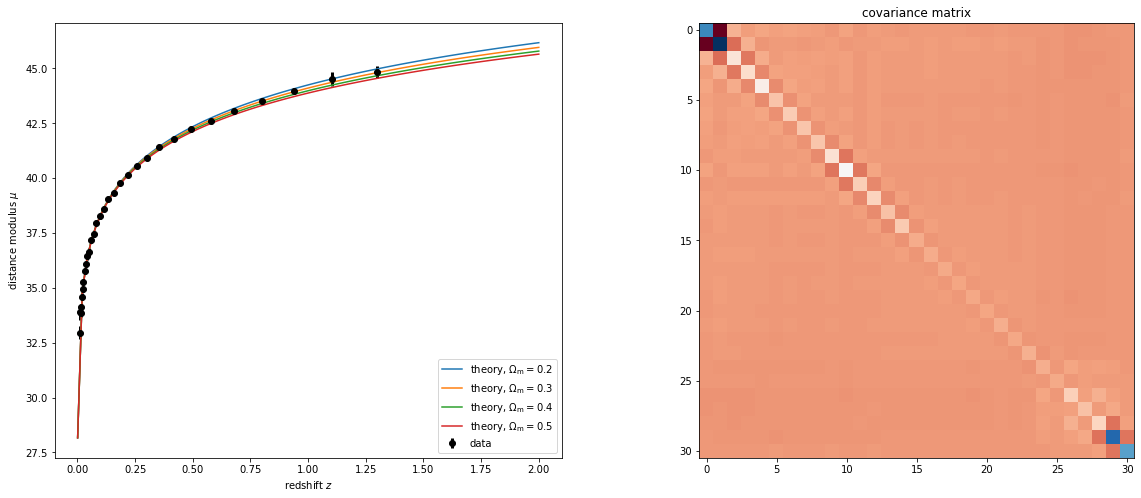

In [5]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))

for Omega_m in [0.2,0.3,0.4,0.5]:
    ax0.plot(zs,mus[Omega_m],label="theory, $\Omega_\mathrm{m}=$"+str(Omega_m))
ax0.errorbar(zdata,data,2*np.sqrt(np.diagonal(cov)),ls="",lw=3,marker="o",color="black",label="data")

ax0.set_xlabel("redshift $z$")
ax0.set_ylabel("distance modulus $\mu$")
ax0.legend(loc="lower right")

ax1.imshow(cov,cmap="RdBu")
ax1.set_title("covariance matrix")

## Log-likelihood

In [6]:
def target_logpdf(theta,zdata,data,cov,Ncalls=-1):
    Omega_m, h = theta[0], theta[1]
    theory = mu(zdata, Omega_m, h)
    ans = ss.multivariate_normal.logpdf(theory,mean=data,cov=cov)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

In [7]:
target_logpdf([0.3,0.7], zdata,data,cov)

44.512718286754016

## Metropolis-Hastings sampler

In [8]:
def uniform_proposal_pdf(sigmaO, sigmah):
    return ss.uniform(loc=[-sigmaO*np.sqrt(3),-sigmah*np.sqrt(3)], scale=[2*sigmaO*np.sqrt(3),2*sigmah*np.sqrt(3)])

def gaussian_proposal_pdf(sigmaO, sigmah):
    return ss.multivariate_normal([0,0],[[sigmaO*sigmaO,0],[0,sigmah*sigmah]])

def proposal_pdf(sigmaO, sigmah):
#     return uniform_proposal_pdf(sigmaO, sigmah)
    return gaussian_proposal_pdf(sigmaO, sigmah)

In [9]:
def MH_sampler(Ntries,theta_start,zdata,data,cov,proposal_sigma):
    Naccepted=0
    samples=list()
    samples.append(theta_start)
    theta=theta_start
    sigmaO, sigmah = proposal_sigma[0], proposal_sigma[1]
    for i in range(Ntries):
        theta_p = theta + proposal_pdf(sigmaO, sigmah).rvs()
        # the uniform/Gaussian proposal pdf satisfies the detailed balance equation, so the
        # acceptance ratio simplifies to the Metropolis ratio
        a = min(1, np.exp(target_logpdf(theta_p,zdata,data,cov) - target_logpdf(theta,zdata,data,cov)))
        u = ss.uniform().rvs()
        if u < a:
            Naccepted+=1
            theta=theta_p
        samples.append(theta)
    return Naccepted, np.array(samples)

In [10]:
Ntries1=1000
Nburnin=100
proposal_sigma=np.array([0.015,0.02])
theta_start=np.array([0.5,0.5])
Naccepted, samples = MH_sampler(Ntries1,theta_start,zdata,data,cov,proposal_sigma)
fraction_accepted=float(Naccepted)/Ntries1

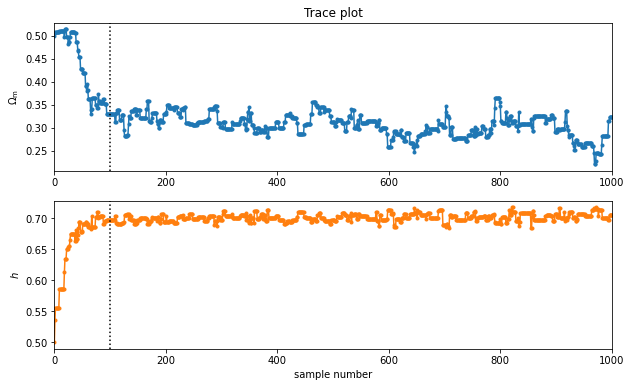

In [11]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10,6))
ax0.set_xlim(0,Ntries1+1)
ax0.set_title("Trace plot")
ax0.set_ylabel("$\Omega_\mathrm{m}$")
ax0.plot(np.arange(Ntries1+1),samples.T[0],marker='.',color='C0')
ymin, ymax = ax0.get_ylim()
ax0.set_ylim([ymin,ymax])
ax0.plot([Nburnin,Nburnin],[ymin,ymax],color='black',linestyle=':')

ax1.set_xlim(0,Ntries1+1)
ax1.set_ylabel("$h$")
ax1.plot(np.arange(Ntries1+1),samples.T[1],marker='.',color='C1')
ax1.set_xlabel("sample number")
ymin, ymax = ax1.get_ylim()
ax1.set_ylim([ymin,ymax])
ax1.plot([Nburnin,Nburnin],[ymin,ymax],color='black',linestyle=':')

In [12]:
fraction_accepted

0.276

## Markov Chain diagnostics

### 1- Step size

In [13]:
Ntries2=1000
theta_start=np.array([0.5,0.5])

In [14]:
# Suitable step size
proposal_sigma_1=np.array([0.02,0.02])
Naccepted_1, samples_1 = MH_sampler(Ntries2,theta_start,zdata,data,cov,proposal_sigma_1)
fraction_accepted_1=float(Naccepted_1)/Ntries2

In [15]:
# Step size too large
proposal_sigma_2=np.array([0.08,0.08])
Naccepted_2, samples_2 = MH_sampler(Ntries2,theta_start,zdata,data,cov,proposal_sigma_2)
fraction_accepted_2=float(Naccepted_2)/Ntries2

In [16]:
# Step size too small
proposal_sigma_3=np.array([2e-3,2e-3])
Naccepted_3, samples_3 = MH_sampler(Ntries2,theta_start,zdata,data,cov,proposal_sigma_3)
fraction_accepted_3=float(Naccepted_3)/Ntries2

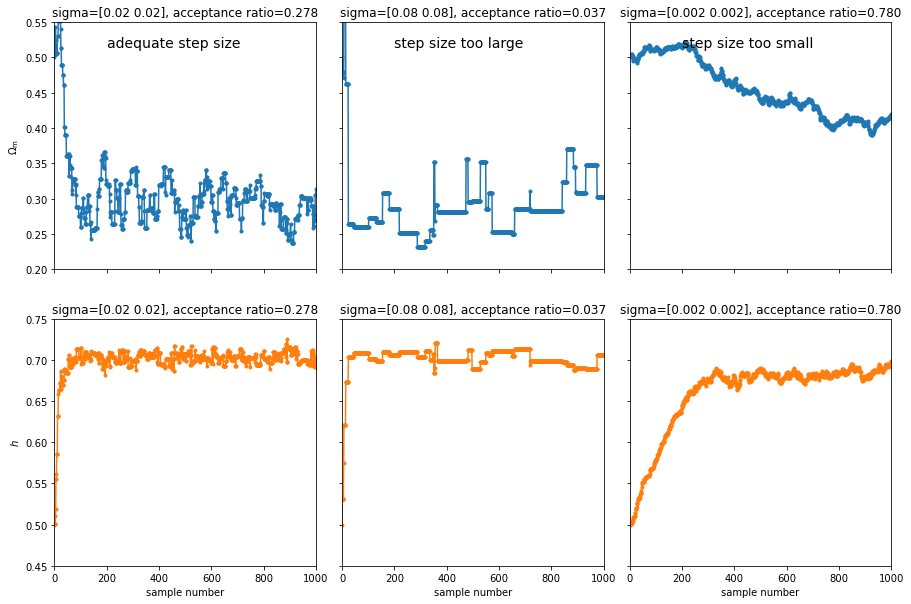

In [17]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,10))
ax1.set_xlim(0,Ntries2)
ax1.set_ylim([0.2,0.55])
ax1.set_ylabel("$\Omega_\mathrm{m}$")
ax1.plot(np.arange(Ntries2+1),samples_1.T[0],marker='.',color='C0')
ax1.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_1,fraction_accepted_1))
ax2.set_xlim(0,Ntries2)
ax2.plot(np.arange(Ntries2+1),samples_2.T[0],marker='.',color='C0')
ax2.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_2,fraction_accepted_2))
ax3.set_xlim(0,Ntries2)
ax3.plot(np.arange(Ntries2+1),samples_3.T[0],marker='.',color='C0')
ax3.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_3,fraction_accepted_3))
ax4.set_xlim(0,Ntries2)
ax4.set_ylim([0.45,0.75])
ax4.set_xlabel("sample number")
ax4.set_ylabel("$h$")
ax4.plot(np.arange(Ntries2+1),samples_1.T[1],marker='.',color='C1')
ax4.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_1,fraction_accepted_1))
ax5.set_xlim(0,Ntries2)
ax5.set_xlabel("sample number")
ax5.plot(np.arange(Ntries2+1),samples_2.T[1],marker='.',color='C1')
ax5.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_2,fraction_accepted_2))
ax6.set_xlim(0,Ntries2)
ax6.set_xlabel("sample number")
ax6.plot(np.arange(Ntries2+1),samples_3.T[1],marker='.',color='C1')
ax6.set_title("sigma={}, acceptance ratio={:.3f}".format(proposal_sigma_3,fraction_accepted_3))
ymin, ymax = ax1.get_ylim()
ax1.text(200,ymax-(ymax-ymin)/10., "adequate step size",fontsize=14)
ax2.text(200,ymax-(ymax-ymin)/10., "step size too large",fontsize=14)
ax3.text(200,ymax-(ymax-ymin)/10., "step size too small",fontsize=14)
f.subplots_adjust(wspace=0.1)

### 2- Multiple chains, different starting point

In [18]:
Ntries3=5000
Nburnin=100
proposal_sigma=np.array([0.025,0.02])
Nchains=5

In [19]:
# Run Nchains different chains starting at different positions in parameter space
chains = [MH_sampler(Ntries3,theta_start,zdata,data,cov,proposal_sigma)
          for theta_start in np.stack((np.linspace(0.1,0.9,Nchains),np.linspace(0.1,0.9,Nchains)),axis=1)]

/tmp/ipykernel_29917/565551235.py:11: RuntimeWarning: overflow encountered in exp
  a = min(1, np.exp(target_logpdf(theta_p,zdata,data,cov) - target_logpdf(theta,zdata,data,cov)))
/tmp/ipykernel_29917/2868005332.py:8: RuntimeWarning: invalid value encountered in double_scalars
  s=((1.-Omega_m)/Omega_m)**(1/3.)


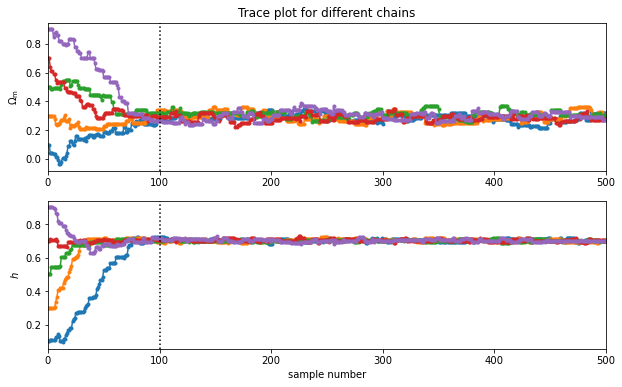

In [20]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10,6))

ax0.set_xlim(0,500)
ax0.set_ylabel("$\Omega_\mathrm{m}$")
for samples in chains:
    ax0.plot(np.arange(Ntries3+1),samples[1].T[0],marker='.')
ymin, ymax = ax0.get_ylim()
ax0.set_ylim([ymin,ymax])
ax0.plot([Nburnin,Nburnin],[ymin,ymax],color='black',linestyle=':')
ax0.set_title("Trace plot for different chains")

ax1.set_xlim(0,500)
ax1.set_ylabel("$h$")
ax1.set_xlabel("sample number")
for samples in chains:
    ax1.plot(np.arange(Ntries3+1),samples[1].T[1],marker='.')
ymin, ymax = ax1.get_ylim()
ax1.set_ylim([ymin,ymax])
ax1.plot([Nburnin,Nburnin],[ymin,ymax],color='black',linestyle=':')

### 3- Gelman-Rubin test

Gelman *et al.*, "*Bayesian Data Analysis*" (third edition), p. 284-285

**Parameters**:
* $m$: number of chains
* $n$: length of chains

**Definitions**:
* "between" chains variance:
\begin{equation}
B \equiv \frac{n}{m-1} \sum_{j=1}^m \left( \bar{\psi}_{. j} - \bar{\psi}_{..} \right)^2 \quad \mathrm{where} \quad \bar{\psi}_{. j} = \frac{1}{n} \sum_{i=1}^n \psi_{ij} \quad \mathrm{and} \quad \bar{\psi}_{..} = \frac{1}{m} \sum_{j=1}^m \bar{\psi}_{.j}
\end{equation}
* "within" chains variance:
\begin{equation}
W \equiv \frac{1}{m} \sum_{j=1}^m s_j^2 \quad \mathrm{where} \quad s_j^2 = \frac{1}{n-1} \sum_{i=1}^n \left( \psi_{ij} - \bar{\psi}_{.j} \right)^2
\end{equation}

**Estimators**:
Estimators of the marginal posterior variance of the estimand:
* $\widehat{\mathrm{var}}^- \equiv W$: underestimates the variance
* $\widehat{\mathrm{var}}^+ \equiv \frac{n}{n-1}W + \frac{1}{n} B$: overestimates the variance

**Test**:
* Potential scale reduction factor: $\widehat{R} \equiv \sqrt{\frac{\widehat{\mathrm{var}}^+}{\widehat{\mathrm{var}}^-}}$
* Test: $\widehat{R} \rightarrow 1$ as $n \rightarrow \infty$

In [21]:
def gelman_rubin(chain):
    # between chains variance
    Psi_dotj = np.mean(chain, axis=1)
    Psi_dotdot = np.mean(Psi_dotj, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1.) * np.sum((Psi_dotj - Psi_dotdot)**2, axis=0)
    
    # within chains variance
    sj2 = np.var(chain, axis=1, ddof=1)
    W = np.mean(sj2, axis=0)
    
    # estimators
    var_minus = W
    var_plus = (n - 1.) / n * W + 1. / n * B
    R_hat = np.sqrt(var_plus / var_minus)
    return R_hat

# The input array must have dimensions (nchains, nsamp, npars) = (m, n, npars).

In [22]:
chain = np.array([chains[j][1] for j in range(Nchains)])
gelman_rubin(chain)

array([1.0034271, 1.0036837])

## Likelihood

In [23]:
# Remove burn-in phase
chain_burn = np.array([chains[j][1][Nburnin:] for j in range(Nchains)])
chain_burn_flat = np.concatenate(chain_burn, axis=0)

In [24]:
# Means of parameters (h, Omega_m)
chain_burn.mean(axis=(0,1))

array([0.29970846, 0.70246689])

In [25]:
# Marginal standard deviations of parameters (h, Omega_m)
chain_burn.std(axis=(0,1))

array([0.03016175, 0.00697043])

In [26]:
# Covariance matrix of parameters (h, Omega_m)
np.cov(chain_burn_flat.T)

array([[ 9.09768225e-04, -1.24560983e-04],
       [-1.24560983e-04,  4.85888204e-05]])

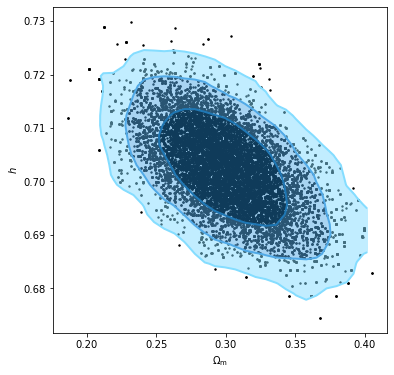

In [27]:
nBins = 30
nContourLevels = 3
# 2d contour levels: (68%, 95%, 99%)
confLevels = [.3173, .0455, .0027]
smoothingKernel = 1

# Empty arrays needed below
chainLevels = np.ones(nContourLevels+1)
extents = np.empty(4)

# These are needed to compute the contour levels
nBinsFlat = np.linspace(0., nBins**2, nBins**2)

# Create 2d histogram
hist2d, xedges, yedges = np.histogram2d(
    chain_burn_flat.T[0], chain_burn_flat.T[1], weights=np.ones_like(chain_burn_flat.T[0]), bins=nBins)
# image extent, needed below for contour lines
extents = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# Normalize
hist2d = hist2d/np.sum(hist2d)
# Cumulative 1d distribution
histOrdered = np.sort(hist2d.flat)
histCumulative = np.cumsum(histOrdered)

# Compute contour levels (from low to high for technical reasons)
for l in range(nContourLevels):
    # Find location of contour level in 1d histCumulative
    temp = np.interp(confLevels[l], histCumulative, nBinsFlat)
    # Find "height" of contour level
    chainLevels[nContourLevels-1-l] = np.interp(temp, nBinsFlat, histOrdered)

# Apply Gaussian smoothing
contours = scipy.ndimage.gaussian_filter(hist2d.T, sigma=smoothingKernel)
    
xbins = (xedges[1:]+xedges[:-1])/2
ybins = (yedges[1:]+yedges[:-1])/2

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(chain_burn_flat.T[0], chain_burn_flat.T[1], color="black", s=2)
ax.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax.set_xlabel("$\Omega_\mathrm{m}$")
ax.set_ylabel("$h$")

plt.show()

## Importance sampling

In [28]:
def prior_pdf(theta):
    Omega_m, h = theta[0], theta[1]
    h_mean=0.738
    h_std=0.024
    return ss.norm(loc=h_mean,scale=h_std).pdf(h)

In [29]:
prior_pdf([0.3,0.72])

12.54739300645018

In [30]:
weights=np.array([prior_pdf(chain_burn_flat[n]) for n in range(chain_burn_flat.shape[0])])
weights/=np.sum(weights)

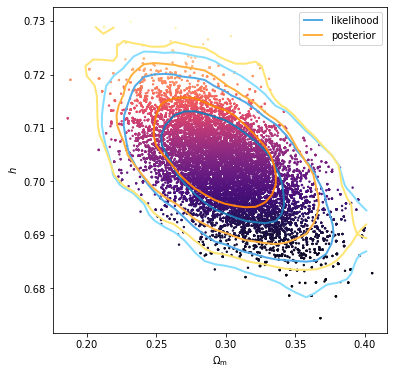

In [31]:
nBins = 30
nContourLevels = 3
# 2d contour levels: (68%, 95%, 99%)
confLevels = [.3173, .0455, .0027]
smoothingKernel = 1

# Empty arrays needed below
chainLevels = np.ones(nContourLevels+1)
extents = np.empty(4)

# These are needed to compute the contour levels
nBinsFlat = np.linspace(0., nBins**2, nBins**2)

# Create 2d histogram
hist2d, xedges, yedges = np.histogram2d(
    chain_burn_flat.T[0], chain_burn_flat.T[1], weights=weights, bins=nBins)
# image extent, needed below for contour lines
extents = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# Normalize
hist2d = hist2d/np.sum(hist2d)
# Cumulative 1d distribution
histOrdered = np.sort(hist2d.flat)
histCumulative = np.cumsum(histOrdered)

# Compute contour levels (from low to high for technical reasons)
for l in range(nContourLevels):
    # Find location of contour level in 1d histCumulative
    temp = np.interp(confLevels[l], histCumulative, nBinsFlat)
    # Find "height" of contour level
    chainLevels[nContourLevels-1-l] = np.interp(temp, nBinsFlat, histOrdered)

# Apply Gaussian smoothing
contours_posterior = scipy.ndimage.gaussian_filter(hist2d.T, sigma=smoothingKernel)
    
xbins = (xedges[1:]+xedges[:-1])/2
ybins = (yedges[1:]+yedges[:-1])/2

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(chain_burn_flat.T[0], chain_burn_flat.T[1], c=weights, s=2, cmap="magma")
cs0 = ax.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
cs1 = ax.contour(xbins, ybins, contours_posterior, levels=chainLevels,
    colors=('#ffe574','#ffb241','#ff7f0e'), linewidths=2)
ax.set_xlabel("$\Omega_\mathrm{m}$")
ax.set_ylabel("$h$")

cs0.collections[1].set_label("likelihood")
cs1.collections[1].set_label("posterior")

ax.legend()
plt.show()

In [32]:
# Mean Omega_m,h with a flat prior
np.average(chain_burn_flat, axis=0)

array([0.29970846, 0.70246689])

In [33]:
# Mean Omega_m,h with the Gaussian prior on h
np.average(chain_burn_flat, weights=weights, axis=0)

array([0.29270455, 0.70522576])

## Hamiltonian Monte Carlo

### Potential

In [34]:
def psi(x,y,Ncalls=-1):
    # psi(x,y)=-ln(target_joint(x,y))
    ans = -target_logpdf([x,y],zdata,data,cov)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans
    
# To get approximate derivatives, we approximate psi
# by a bivariate Gaussian with mean and covariance
# estimated from the MCMC result:
# psi = 1/2 * (theta-theta_m)^T C^{-1} (theta-theta_m)
# dpsi/dx = C^{-1} (theta-theta_m)[x]

theta_m = chain_burn.mean(axis=(0,1))
theta_C = np.cov(chain_burn_flat.T)
theta_P = np.linalg.inv(theta_C)

def approx_psi(x,y,Ncalls=-1):
    ans = 1/2.*(np.array([x,y])-theta_m).T.dot(theta_P).dot(np.array([x,y])-theta_m)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

def dpsi_dx(x,y,Ncalls=-1):
    ans = theta_P.dot(np.array([x,y])-theta_m)[0]
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans
def dpsi_dy(x,y,Ncalls=-1):
    ans = theta_P.dot(np.array([x,y])-theta_m)[1]
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

In [35]:
xmin=0.15
xmax=0.55
ymin=0.65
ymax=0.74
x=np.linspace(xmin,xmax,100)
y=np.linspace(ymin,ymax,100)
X,Y=np.meshgrid(x,y)
Psi=[[psi(xi,yi) for xi in x] for yi in y]
APsi=[[approx_psi(xi,yi) for xi in x] for yi in y]
dPsi_dx=[[dpsi_dx(xi,yi) for xi in x] for yi in y]
dPsi_dy=[[dpsi_dy(xi,yi) for xi in x] for yi in y]

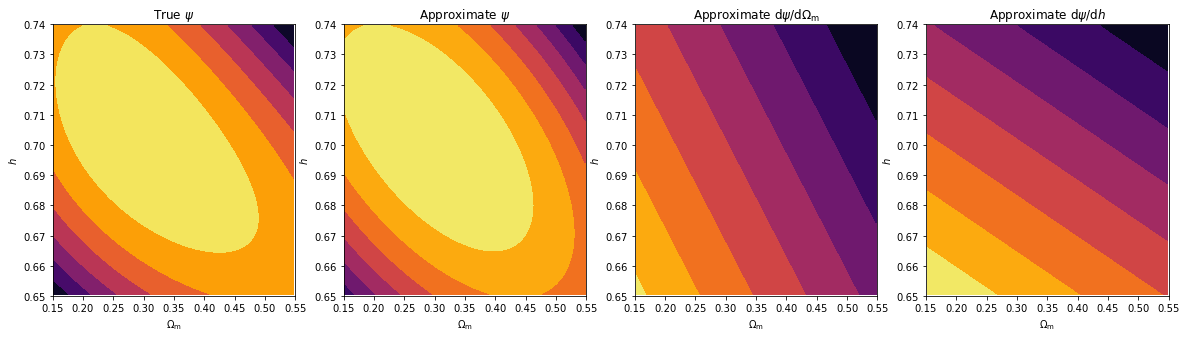

In [36]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,5))

ax0.set_xlim(xmin,xmax)
ax0.set_ylim(ymin,ymax)
ax0.set_xlabel("$\Omega_\mathrm{m}$")
ax0.set_ylabel("$h$")
ax0.set_title("True $\psi$")
ax0.contourf(Psi,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='inferno_r')
ax1.set_xlim(xmin,xmax)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel("$\Omega_\mathrm{m}$")
ax1.set_ylabel("$h$")
ax1.set_title("Approximate $\psi$")
ax1.contourf(APsi,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='inferno_r')
ax2.set_xlim(xmin,xmax)
ax2.set_ylim(ymin,ymax)
ax2.set_xlabel("$\Omega_\mathrm{m}$")
ax2.set_ylabel("$h$")
ax2.set_title("Approximate $\mathrm{d}\psi / \mathrm{d}\Omega_\mathrm{m}$")
ax2.contourf(dPsi_dx,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='inferno_r')
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
ax3.set_xlabel("$\Omega_\mathrm{m}$")
ax3.set_ylabel("$h$")
ax3.set_title("Approximate $\mathrm{d}\psi / \mathrm{d}h$")
ax3.contourf(dPsi_dy,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='inferno_r')

### Autocorrelation diagnostics

In [37]:
# Python code from the emcee tutorials, https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

def next_power_of_2(n):
    from math import ceil, log2
    return 1 if n == 0 else 2**ceil(log2(n))

# 1D autocorrelation function
def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    n = next_power_of_2(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def N_eff(x):
    acf=autocorr_gw2010(x)
    return len(x)/acf

### Sampler

In [38]:
def leapfrog_move(dpsi_dx,dpsi_dy,Ncalls_psi_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,epsilon):
    # Kick: make half step in p_x, p_y
    p_x -= epsilon*dpsidx/2.0
    p_y -= epsilon*dpsidy/2.0
    # compute velocities
    p = np.array((p_x,p_y))
    v_x,v_y = InvMassMatrix.dot(p)
    # Drift: make full step in (x,y)
    new_x = x+epsilon*v_x
    new_y = y+epsilon*v_y
    # compute new gradient
    dpsidx, Ncalls_psi_current = dpsi_dx(new_x,new_y,Ncalls=Ncalls_psi_current)
    dpsidy, Ncalls_psi_current = dpsi_dy(new_x,new_y,Ncalls=Ncalls_psi_current)
    # Kick: make half step in p_x, p_y
    p_x -= epsilon*dpsidx/2.0
    p_y -= epsilon*dpsidy/2.0
    
    return dpsidx,dpsidy,new_x,new_y,p_x,p_y,Ncalls_psi_current

def Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepsize,Ntries,x_start,y_start):
    from math import floor
    InvMassMatrix=np.linalg.inv(MassMatrix)
    Naccepted=0
    x=x_start
    y=y_start
    samples_x=[x]
    samples_y=[y]
    Ncalls_psi=[0]
    Ncalls_psi_current=0
    Neff_x=[0]
    Neff_y=[0]
    for _ in range(Ntries):
        # compute potential energy and gradient
        old_x = x
        old_y = y
        old_psi, Ncalls_psi_current = psi(old_x,old_y,Ncalls=Ncalls_psi_current)
        dpsidx, Ncalls_psi_current = dpsi_dx(old_x,old_y,Ncalls=Ncalls_psi_current)
        dpsidy, Ncalls_psi_current = dpsi_dy(old_x,old_y,Ncalls=Ncalls_psi_current)
        
        # randomly draw momenta
        p_x = ss.norm(0.,1.).rvs()
        p_y = ss.norm(0.,1.).rvs()
        p = np.array((p_x,p_y))
        
        # compute kinetic energy
        old_K = p.T.dot(InvMassMatrix).dot(p)/2.
        
        # compute Hamiltonian
        old_H = old_K + old_psi
        
        # do leapfrog integration steps
        Nsteps = 1+floor(ss.uniform.rvs()*Neval)
        for step in range(Nsteps):
            # draw stepsize
            epsilon = ss.uniform.rvs()*stepsize
            
            # call leapfrog move
            dpsidx,dpsidy,x,y,p_x,p_y,Ncalls_psi_current = leapfrog_move(dpsi_dx,dpsi_dy,Ncalls_psi_current,InvMassMatrix,dpsidx,dpsidy,x,y,p_x,p_y,epsilon)
        
        # compute new energy and Hamiltonian
        new_x=x; new_y=y
        new_psi = psi(new_x,new_y)
        p = np.array((p_x,p_y))
        new_K = p.T.dot(InvMassMatrix).dot(p)/2.
        new_H = new_K + new_psi
        dH = new_H - old_H
        
        # accept/reject new candidate x,y using the standard Metropolis-Hastings rule
        if(x<0.):
            accept=False
        else:
            if(dH<0.0):
                accept=True
            else:
                a = np.exp(-dH)
                u = np.random.uniform()
                if(u < a):
                    accept=True
                else:
                    accept=False
                    
        if(accept):
            x=new_x
            y=new_y
            Naccepted+=1
        else:
            x=old_x
            y=old_y
        samples_x.append(x)
        samples_y.append(y)
        Ncalls_psi.append(Ncalls_psi_current)
        Neff_x.append(N_eff(samples_x))
        Neff_y.append(N_eff(samples_y))

    return Naccepted, np.array(samples_x), np.array(samples_y), np.array(Ncalls_psi), np.array(Neff_x), np.array(Neff_y)

In [39]:
Ntries=100
x_start=0.5
y_start=0.5
MassMatrix=np.array([[60, 0.], [0., 70]])
Neval=9
stepsize=0.1
Naccepted,samples_x,samples_y,Ncalls_psi_HMC,Neff_x_HMC,Neff_y_HMC=Hamiltonian_leapfrog_sampler(psi,dpsi_dx,dpsi_dy,MassMatrix,Neval,stepsize,Ntries,x_start,y_start)

/tmp/ipykernel_29917/2355215352.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return len(x)/acf


In [40]:
Naccepted/Ntries

0.85

Text(0.5, 0, 'sample number')

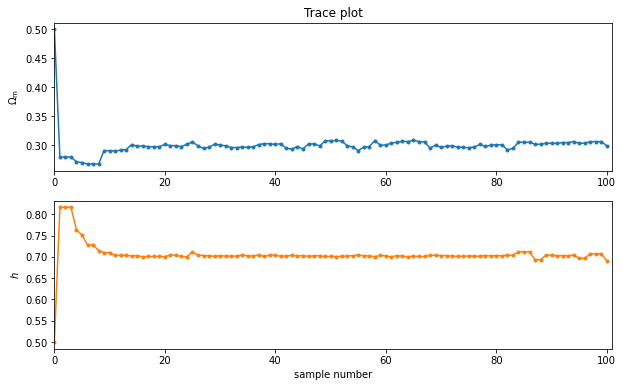

In [41]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(10,6))
ax0.set_xlim(0,Ntries+1)
ax0.set_title("Trace plot")
ax0.set_ylabel("$\Omega_\mathrm{m}$")
ax0.plot(np.arange(Ntries+1),samples_x,marker='.',color='C0')

ax1.set_xlim(0,Ntries+1)
ax1.set_ylabel("$h$")
ax1.plot(np.arange(Ntries+1),samples_y,marker='.',color='C1')
ax1.set_xlabel("sample number")

### Comparison to MH: effective sample size per function evaluation

In [42]:
def MH_sampler_count(Ntries,theta_start,zdata,data,cov,proposal_sigma):
    Naccepted=0
    samples=list()
    samples.append(theta_start)
    samples_x=list()
    samples_y=list()
    Ncalls_psi=[0]
    Ncalls_psi_current=0
    Neff_x=[0]
    Neff_y=[0]
    theta=theta_start
    sigmaO, sigmah = proposal_sigma[0], proposal_sigma[1]
    for i in range(Ntries):
        theta_p = theta + proposal_pdf(sigmaO, sigmah).rvs()
        # the uniform/Gaussian proposal pdf satisfies the detailed balance equation, so the
        # acceptance ratio simplifies to the Metropolis ratio
        current_logpdf, Ncalls_psi_current = target_logpdf(theta_p,zdata,data,cov, Ncalls_psi_current)
        proposal_logpdf, Ncalls_psi_current = target_logpdf(theta,zdata,data,cov,Ncalls_psi_current)
        a = min(1, np.exp(current_logpdf - proposal_logpdf))
        u = ss.uniform().rvs()
        if u < a:
            Naccepted+=1
            theta=theta_p
        samples.append(theta)
        samples_x.append(theta[0])
        samples_y.append(theta[1])
        Ncalls_psi.append(Ncalls_psi_current)
        Neff_x.append(N_eff(samples_x))
        Neff_y.append(N_eff(samples_y))
    return Naccepted, np.array(samples), np.array(Ncalls_psi), np.array(Neff_x), np.array(Neff_y)

In [43]:
Ntries=1000
proposal_sigma=np.array([0.02,0.02])
theta_start=np.array([0.5,0.5])
Naccepted, samples, Ncalls_psi_MH, Neff_x_MH, Neff_y_MH = MH_sampler_count(Ntries,theta_start,zdata,data,cov,proposal_sigma)
fraction_accepted=float(Naccepted)/Ntries

/tmp/ipykernel_29917/2355215352.py:19: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/tmp/ipykernel_29917/2355215352.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  return len(x)/acf


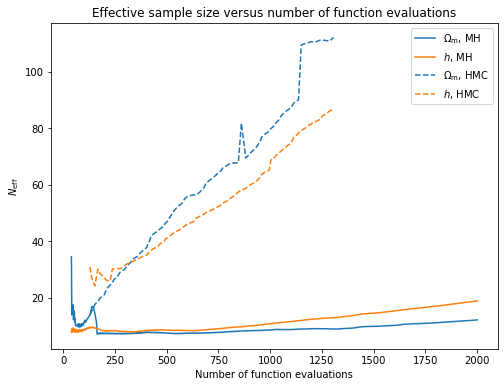

In [44]:
plt.figure(figsize=(8,6))
plt.plot(Ncalls_psi_MH[20:],Neff_x_MH[20:],color="C0",ls="-",label="$\Omega_\mathrm{m}$, MH")
plt.plot(Ncalls_psi_MH[20:],Neff_y_MH[20:],color="C1",ls="-",label="$h$, MH")
plt.plot(Ncalls_psi_HMC[10:],Neff_x_HMC[10:],color="C0",ls="--",label="$\Omega_\mathrm{m}$, HMC")
plt.plot(Ncalls_psi_HMC[10:],Neff_y_HMC[10:],color="C1",ls="--",label="$h$, HMC")
plt.xlabel("Number of function evaluations")
plt.ylabel("$N_\mathrm{eff}$")
plt.title("Effective sample size versus number of function evaluations")
plt.legend(loc="best")

## Theory (three-parameter problem)

### Exact calculation

In [45]:
def mu3(z,Omega_m,h,Omega_v):
    return 25. - 5.*np.log10(h) + 5.*np.log10(D_L3(z,Omega_m,Omega_v))

def r(z,Omega_m,Omega_v):
    from scipy.integrate import quad
    
    Omega_k = 1 - Omega_m - Omega_v
    
    def integrand(z,Omega_m,Omega_k,Omega_v):
        return 1./np.sqrt(Omega_m*(1+z)**3 + Omega_k*(1+z)**2 + Omega_v)
    
    z = np.atleast_1d(z)
    I = np.array([quad(integrand, 0, zi, args=(Omega_m,Omega_k,Omega_v))[0] for zi in z])
    return I

def S_k(r,Omega_m,Omega_v):
    Omega_k = 1 - Omega_m - Omega_v
    if Omega_k>0:
        return np.sin(np.sqrt(np.abs(Omega_k))*r)
    elif Omega_k<0:
        return np.sinh(np.sqrt(np.abs(Omega_k))*r)

def D_L3(z,Omega_m,Omega_v):
    Omega_k = 1 - Omega_m - Omega_v
    if np.abs(Omega_k)>0:
        return 3000.*(1+z)*1/np.sqrt(np.abs(Omega_k))*S_k(r(z,Omega_m,Omega_v),Omega_m,Omega_v)
    else:
        return 3000.*(1+z)*r(z,Omega_m,Omega_v)

In [46]:
D_L(1.,0.3), D_L3(1.,0.3,0.7), D_L3(1.,0.3,0.71)

(4632.178183314667, array([4628.56239857]), array([4647.17251753]))

In [47]:
zs=np.linspace(1e-3,2,100)
Omega_m=0.3
h=0.7
mus={}
for Omega_v in [0.6,0.7,0.8]:
    mus[Omega_v]=mu3(zs,Omega_m,h,Omega_v)

Text(0.5, 1.0, 'covariance matrix')

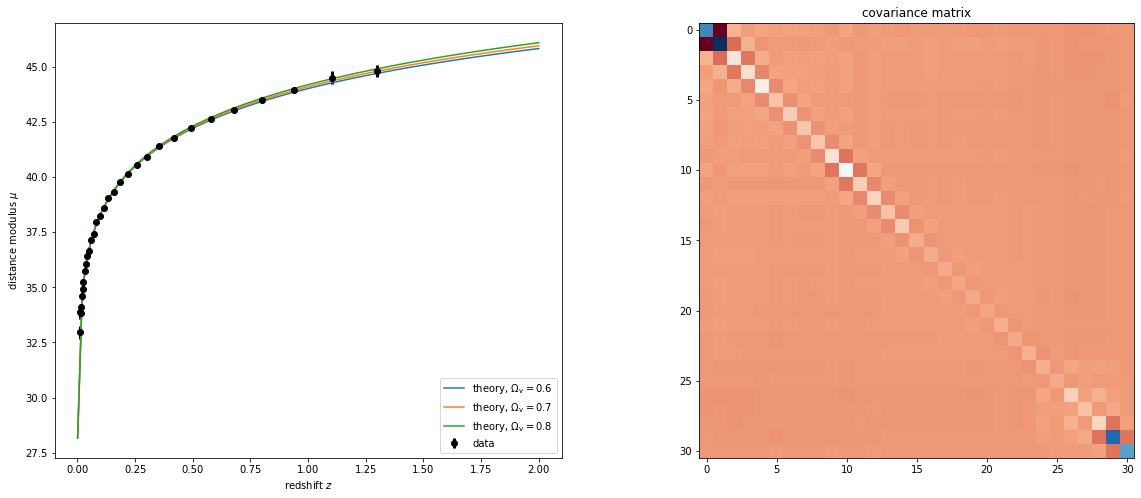

In [48]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))

for Omega_v in [0.6,0.7,0.8]:
    ax0.plot(zs,mus[Omega_v],label="theory, $\Omega_\mathrm{v}=$"+str(Omega_v))
ax0.errorbar(zdata,data,2*np.sqrt(np.diagonal(cov)),ls="",lw=3,marker="o",color="black",label="data")

ax0.set_xlabel("redshift $z$")
ax0.set_ylabel("distance modulus $\mu$")
ax0.legend(loc="lower right")

ax1.imshow(cov,cmap="RdBu")
ax1.set_title("covariance matrix")

### Interpolation

In [49]:
from scipy.interpolate import interp2d
x = np.linspace(1e-4, 1., 100)
y = np.linspace(1e-4, 1., 100)
xx, yy = np.meshgrid(x, y)
z = np.array([[D_L3(zdata,xi,yi) for xi in x] for yi in y])
f={}
for n in range(len(zdata)):
    f[n] = interp2d(x, y, z[:,:,n])
    
def D_L3_interp(Omega_m,Omega_v):
    return np.array([f[n](Omega_m,Omega_v)[0] for n in range(len(zdata))])

def mu3_interp(Omega_m,h,Omega_v):
    return 25. - 5.*np.log10(h) + 5.*np.log10(D_L3_interp(Omega_m,Omega_v))

In [50]:
mu3(zdata,0.2,0.7,0.85), mu3_interp(0.2,0.7,0.85)

(array([33.17899561, 33.57864895, 33.9171205 , 34.21080835, 34.5895509 ,
        35.01182182, 35.28357467, 35.67467887, 36.06979813, 36.40696897,
        36.79180118, 37.16065082, 37.51289302, 37.87719862, 38.26747049,
        38.64645833, 39.03004103, 39.42588432, 39.82324253, 40.2154906 ,
        40.62846866, 41.03998394, 41.45925523, 41.89000936, 42.32139557,
        42.76532817, 43.2096594 , 43.66388846, 44.12157076, 44.57965953,
        45.04117174]),
 array([33.17899561, 33.57864896, 33.9171205 , 34.21080835, 34.58955091,
        35.01182183, 35.28357468, 35.67467889, 36.06979816, 36.406969  ,
        36.79180123, 37.16065089, 37.51289312, 37.87719875, 38.26747068,
        38.64645858, 39.03004139, 39.42588483, 39.82324324, 40.21549157,
        40.62847003, 41.03998586, 41.4592579 , 41.89001309, 42.32140073,
        42.7653353 , 43.20966909, 43.66390154, 44.12158811, 44.57968205,
        45.04120034]))

### Log-likelihood and log-posterior

In [51]:
def target_lh3(theta,data,cov,Ncalls=-1):
    Omega_m, h, Omega_v = theta[0], theta[1], theta[2]
    
    # Likelihood part
    theory = mu3_interp(Omega_m,h,Omega_v)
    ans = ss.multivariate_normal.logpdf(theory,mean=data,cov=cov)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans
    
def target_logpdf3(theta,data,cov,Ncalls=-1):
    Omega_m, h, Omega_v = theta[0], theta[1], theta[2]
    
    # Prior part
    theta_mean = np.array([0.3,0.7,0.7])
    theta_cov = np.array([[0.1**2,0,0],[0,0.1**2,0],[0,0,0.1**2]])
    ans = ss.multivariate_normal.logpdf(theta,mean=theta_mean,cov=theta_cov)
    
    # Likelihood part
    theory = mu3_interp(Omega_m,h,Omega_v)
    ans += ss.multivariate_normal.logpdf(theory,mean=data,cov=cov)
    if Ncalls>=0:
        return ans, Ncalls+1
    else:
        return ans

In [52]:
target_lh3([0.3,0.7,0.7],data,cov), target_lh3([0.3,0.7,0.8],data,cov)

(44.68689014108202, 41.20152784047073)

### Metropolis-Hastings sampler

In [53]:
def proposal_pdf(proposal_cov):
    # We introduce an correlations or anti-correlations between parameters in the proposal covariance matrix
    return ss.multivariate_normal([0,0,0],proposal_cov)

In [54]:
def MH_sampler(Ntries,theta_start,zdata,data,cov,proposal_cov):
    Naccepted=0
    samples=list()
    samples.append(theta_start)
    theta=theta_start
    for i in range(Ntries):
        theta_p = theta + proposal_pdf(proposal_cov).rvs()
        # the uniform/Gaussian proposal pdf satisfies the detailed balance equation, so the
        # acceptance ratio simplifies to the Metropolis ratio
        a = min(1, np.exp(target_logpdf3(theta_p,data,cov) - target_logpdf3(theta,data,cov)))
        u = ss.uniform().rvs()
        if u < a:
            Naccepted+=1
            theta=theta_p
        samples.append(theta)
    return Naccepted, np.array(samples)

In [55]:
Ntries1=10000
Nburnin=100
# proposal_cov=np.array([[0.02**2, 0, 0],
#                        [0, 0.02**2, 0],
#                        [0, 0, 0.02**2]])
proposal_cov=np.array([[ 7.93310918e-03, -7.96384748e-05,  3.26106044e-03],
                       [-7.96384748e-05,  4.91425771e-05,  1.48500330e-04],
                       [ 3.26106044e-03,  1.48500330e-04,  3.20024093e-03]])
theta_start=np.array([0.5,0.5,0.5])
Naccepted, samples = MH_sampler(Ntries1,theta_start,zdata,data,cov,proposal_cov)
fraction_accepted=float(Naccepted)/Ntries1
fraction_accepted

0.4674

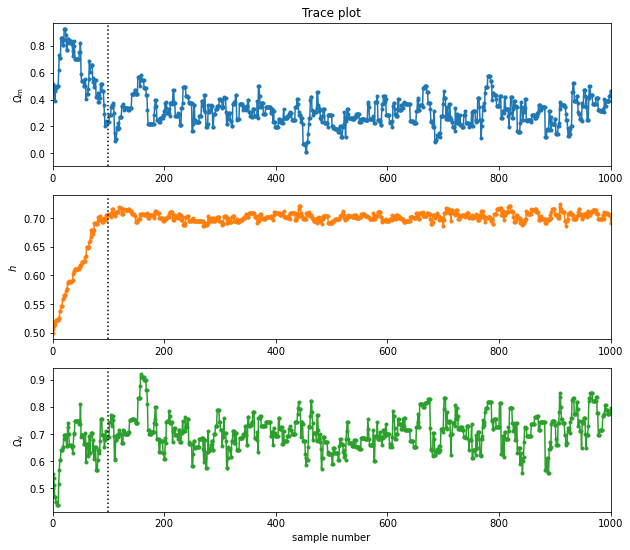

In [56]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1,figsize=(10,9))
ax0.set_xlim(0,1000)
ax0.set_title("Trace plot")
ax0.set_ylabel("$\Omega_\mathrm{m}$")
ax0.plot(np.arange(Ntries1+1),samples.T[0],marker='.',color='C0')
ymin, ymax = ax0.get_ylim()
ax0.set_ylim([ymin,ymax])
ax0.plot([Nburnin,Nburnin],[ymin,ymax],color='black',linestyle=':')

ax1.set_xlim(0,1000)
ax1.set_ylabel("$h$")
ax1.plot(np.arange(Ntries1+1),samples.T[1],marker='.',color='C1')
ymin, ymax = ax1.get_ylim()
ax1.set_ylim([ymin,ymax])
ax1.plot([Nburnin,Nburnin],[ymin,ymax],color='black',linestyle=':')

ax2.set_xlim(0,1000)
ax2.set_ylabel("$\Omega_\mathrm{v}$")
ax2.plot(np.arange(Ntries1+1),samples.T[2],marker='.',color='C2')
ax2.set_xlabel("sample number")
ymin, ymax = ax2.get_ylim()
ax2.set_ylim([ymin,ymax])
ax2.plot([Nburnin,Nburnin],[ymin,ymax],color='black',linestyle=':')

In [57]:
# Remove burn-in phase
samples=samples[Nburnin:,:]

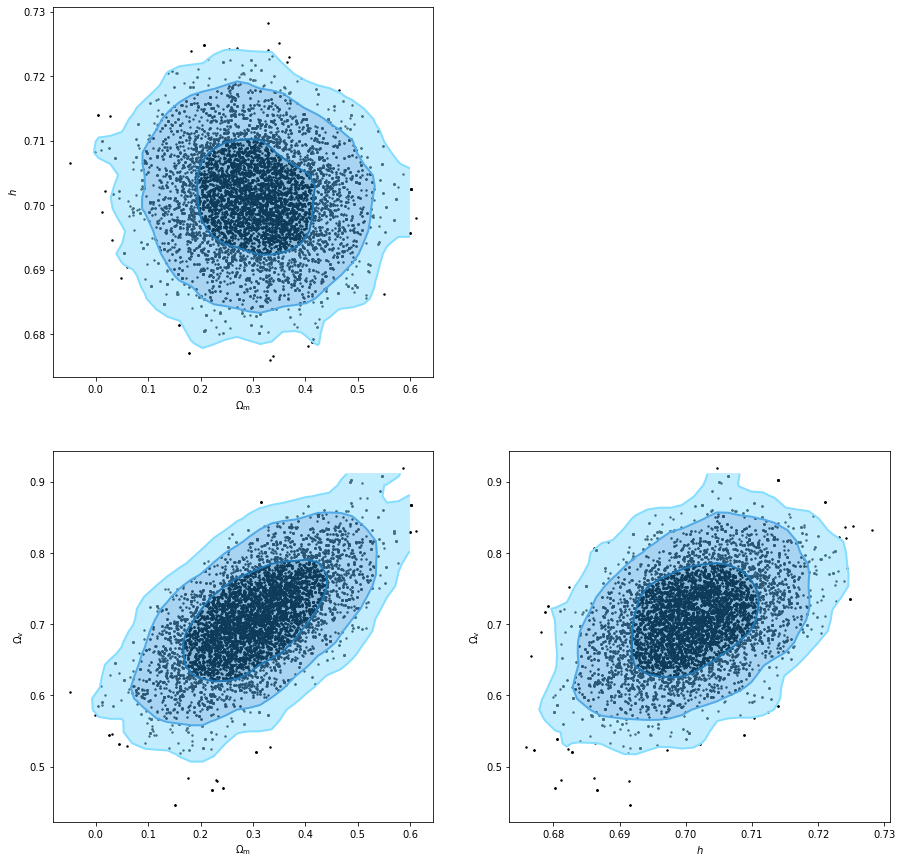

In [58]:
nBins = 30
nContourLevels = 3
# 2d contour levels: (68%, 95%, 99%)
confLevels = [.3173, .0455, .0027]
smoothingKernel = 1

def get_contours(samples_x, samples_y):
    # Empty arrays needed below
    chainLevels = np.ones(nContourLevels+1)
    extents = np.empty(4)

    # These are needed to compute the contour levels
    nBinsFlat = np.linspace(0., nBins**2, nBins**2)

    # Create 2d histogram
    hist2d, xedges, yedges = np.histogram2d(
        samples_x, samples_y, weights=np.ones_like(samples.T[0]), bins=nBins)
    # image extent, needed below for contour lines
    extents = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Normalize
    hist2d = hist2d/np.sum(hist2d)
    # Cumulative 1d distribution
    histOrdered = np.sort(hist2d.flat)
    histCumulative = np.cumsum(histOrdered)

    # Compute contour levels (from low to high for technical reasons)
    for l in range(nContourLevels):
        # Find location of contour level in 1d histCumulative
        temp = np.interp(confLevels[l], histCumulative, nBinsFlat)
        # Find "height" of contour level
        chainLevels[nContourLevels-1-l] = np.interp(temp, nBinsFlat, histOrdered)

    # Apply Gaussian smoothing
    contours = scipy.ndimage.gaussian_filter(hist2d.T, sigma=smoothingKernel)

    xbins = (xedges[1:]+xedges[:-1])/2
    ybins = (yedges[1:]+yedges[:-1])/2
    
    return xbins, ybins, contours

fig = plt.figure(figsize=(15,15))
ax0 = fig.add_subplot(2,2,1)
ax0.scatter(samples.T[0], samples.T[1], color="black", s=2)
xbins, ybins, contours = get_contours(samples.T[0], samples.T[1])
ax0.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax0.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax0.set_xlabel("$\Omega_\mathrm{m}$")
ax0.set_ylabel("$h$")

ax1 = fig.add_subplot(2,2,3)
ax1.scatter(samples.T[0], samples.T[2], color="black", s=2)
xbins, ybins, contours = get_contours(samples.T[0], samples.T[2])
ax1.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax1.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax1.set_xlabel("$\Omega_\mathrm{m}$")
ax1.set_ylabel("$\Omega_\mathrm{v}$")

ax1 = fig.add_subplot(2,2,4)
ax1.scatter(samples.T[1], samples.T[2], color="black", s=2)
xbins, ybins, contours = get_contours(samples.T[1], samples.T[2])
ax1.contourf(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), alpha=0.5)
ax1.contour(xbins, ybins, contours, levels=chainLevels,
    colors=('#85ddff','#52aae7','#1f77b4'), linewidths=2)
ax1.set_xlabel("$h$")
ax1.set_ylabel("$\Omega_\mathrm{v}$")

plt.show()

In [59]:
# Compute the posterior covariance, which can be fed back to the sampler as proposal
np.cov(samples.T)

array([[ 8.55056742e-03, -5.94105442e-05,  3.46250524e-03],
       [-5.94105442e-05,  5.31586633e-05,  1.80012170e-04],
       [ 3.46250524e-03,  1.80012170e-04,  3.49171228e-03]])